# REINFORCE

---

In this notebook, we will train REINFORCE with OpenAI Gym's Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # this avoids an error in matplotlib


import gym
gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [3]:
env = gym.make('CartPole-v0')
env.reset(seed=0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)  # this creates a distribution to sample from 
        action = m.sample() # sample an action from the distribution
        return action.item(), m.log_prob(action)  # why log_prob: translate the multiply to sum

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [4]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        state = state[0]
        for t in range(max_t):
            action, log_prob = policy.act(state)  # select an action and get the log prob of that action
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break 
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R) # why negative? gradient ascent -> gradient descent, then Adam optimizer
        policy_loss = torch.cat(policy_loss).sum()
        
        optimizer.zero_grad()  # zero the gradients
        policy_loss.backward()  # compute the gradients
        optimizer.step()  # update the weights
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque)>=195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores
    
scores = reinforce()

c:\Users\97575\anaconda3\envs\ml-pytorch\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 41.62
Episode 200	Average Score: 92.28
Episode 300	Average Score: 46.94
Episode 400	Average Score: 36.92
Episode 500	Average Score: 70.32
Episode 600	Average Score: 72.85
Environment solved in 589 episodes!	Average Score: 201.37


### 4. Plot the Scores

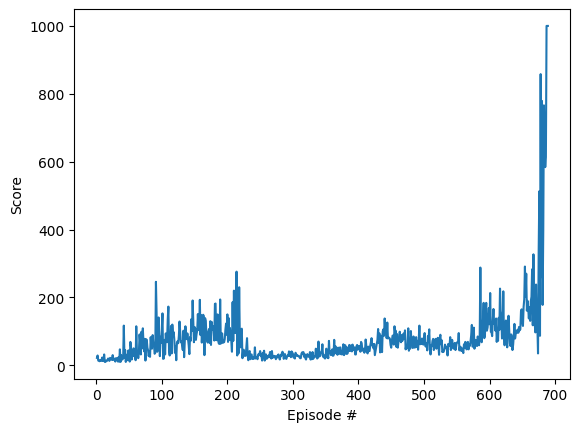

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [9]:
env = gym.make('CartPole-v0', render_mode='human')

state = env.reset()
state = state[0]
for t in range(1000):
    action, _ = policy.act(state)
    env.render()
    state, reward, done, _, _ = env.step(action)
    if done:
        break 

env.close()